# 1. Import Dependencies

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

# 2. Example

In [2]:
class Conv1x1Example(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv1x1Example, self).__init__()
        
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1x1(x)
        x = self.relu(x)
        return x

In [3]:
model = Conv1x1Example(in_channels = 64, out_channels = 32)

In [4]:
input_tensor = torch.randn(1, 64, 56, 56)
output_tensor = model(input_tensor)
print(f"입력 텐서 크기: {input_tensor.shape}")
print(f"출력 텐서 크기: {output_tensor.shape}")

입력 텐서 크기: torch.Size([1, 64, 56, 56])
출력 텐서 크기: torch.Size([1, 32, 56, 56])


# 3. Load Dataset

In [5]:
# Transform 정의
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10 TRAIN 데이터 정의
cifar10_train = datasets.CIFAR10(root="../Data/", train=True, transform=transform, target_transform=None, download=True)

# CIFAR10 TEST 데이터 정의
cifar10_test = datasets.CIFAR10(root="../Data/", train=False, transform=transform, target_transform=None, download=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = DataLoader(cifar10_train, batch_size=100, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=100, shuffle=False)

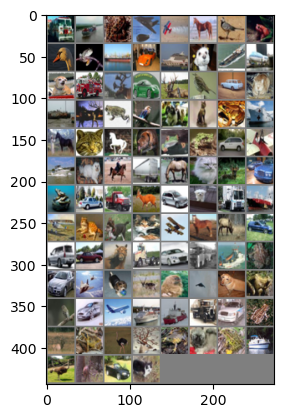

truck  ship  frog plane plane horse  bird  frog  bird  frog  ship   car  ship   dog  ship plane   dog truck  deer   car  deer  bird   car   cat  ship  deer  frog  bird   dog   cat  frog  ship horse   cat horse   dog  frog  frog   car plane  ship   dog horse truck horse   cat  deer   car  frog   car truck  deer   car   dog truck  ship plane   cat   dog   cat plane horse  deer   car   car   car horse truck   car truck  ship  frog   car plane   dog  deer   dog plane   dog  frog  bird   car plane  ship  ship truck   car  frog  deer  frog  bird  deer  frog   dog  frog  ship  bird  deer   car   cat


In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

# 4. Construct Model

In [8]:
# one by one convolution (dimension reduction)
def conv_1(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size = 1, stride = 1),
        nn.ReLU()
    )
    return model

# one by one convolution -> three by three convolution
def conv_1_3(in_dim, mid_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, mid_dim, kernel_size = 1, stride = 1),
        nn.ReLU(),
        nn.Conv2d(mid_dim, out_dim, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU()
    )
    return model

# one by one convolution -> five by five convolution
def conv_1_5(in_dim, mid_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, mid_dim, kernel_size = 1, stride = 1),
        nn.ReLU(),
        nn.Conv2d(mid_dim, out_dim, kernel_size = 5, stride = 1, padding = 2),
        nn.ReLU()
    )
    return model

# three by three maxpooling -> one by one convolution
def max_3_1(in_dim, out_dim):
    model = nn.Sequential(
        nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1),
        nn.Conv2d(in_dim, out_dim, kernel_size = 1, stride = 1),
        nn.ReLU()
    )
    return model

In [9]:
class inception_module(nn.Module):
    def __init__(self,in_dim,out_dim_1,mid_dim_3,out_dim_3,mid_dim_5,out_dim_5,pool_dim):
        super(inception_module,self).__init__()
        # 1x1 Convolution
        self.conv_1 = conv_1(in_dim,out_dim_1)
        
        # 1x1 Convolution -> 3x3 Convolution
        self.conv_1_3 = conv_1_3(in_dim,mid_dim_3,out_dim_3)
        
        # 1x1 Convolution -> 5x5 Convolution
        self.conv_1_5 = conv_1_5(in_dim,mid_dim_5,out_dim_5)
        
        # 3x3 MaxPooling -> 1x1 Convolution
        self.max_3_1 = max_3_1(in_dim,pool_dim)

    def forward(self,x):
        out_1 = self.conv_1(x)
        out_2 = self.conv_1_3(x)
        out_3 = self.conv_1_5(x)
        out_4 = self.max_3_1(x)
        # concat
        output = torch.cat([out_1,out_2,out_3,out_4],1)
        return output

In [13]:
class GoogLeNet(nn.Module):
    def __init__(self, base_dim, num_classes=10):
        super(GoogLeNet, self).__init__()
        self.num_classes=num_classes
        self.layer_1 = nn.Sequential(
            nn.Conv2d(3,base_dim,7,2,3),
            nn.MaxPool2d(3,2,1),
            nn.Conv2d(base_dim,base_dim*3,3,1,1),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_2 = nn.Sequential(
            inception_module(base_dim*3,64,96,128,16,32,32),
            inception_module(base_dim*4,128,128,192,32,96,64),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_3 = nn.Sequential(
            inception_module(480,192,96,208,16,48,64),
            inception_module(512,160,112,224,24,64,64),
            inception_module(512,128,128,256,24,64,64),
            inception_module(512,112,144,288,32,64,64),
            inception_module(528,256,160,320,32,128,128),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_4 = nn.Sequential(
            inception_module(832,256,160,320,32,128,128),
            inception_module(832,384,192,384,48,128,128), 
            nn.AvgPool2d(1,1),
        )
        self.layer_5 = nn.Dropout2d(0.4)
        self.fc_layer = nn.Linear(1024,self.num_classes)
                
        
    def forward(self, x):
        out = self.layer_1(x)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = self.layer_5(out)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        return out

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = GoogLeNet(base_dim=64).to(device)

batch_size = 100
learning_rate = 0.0002
num_epoch = 100

# 손실함수 및 최적화함수 설정
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
loss_arr = []
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

    if i % 10 ==0:
        print(loss)
        loss_arr.append(loss.cpu().detach().numpy())

tensor(1.7939, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5468, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1571, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0305, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0087, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0376, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0067, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1261, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0120, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0489, device='cuda:0', grad_fn=<NllLossBackward0>)


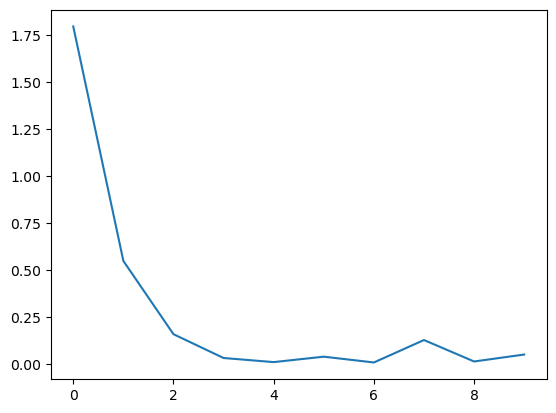

In [16]:
plt.plot(loss_arr)
plt.show()

# 5. Evaluation and Inference

In [17]:
correct = 0
total = 0

model.eval()

with torch.no_grad():
    for image,label in test_loader:
        
        x = image.to(device)
        y= label.to(device)

        output = model.forward(x)
        _,output_index = torch.max(output,1)

        total += label.size(0)
        correct += (output_index == y).sum().float()
        
    print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 72.19999694824219%


In [25]:
classes = cifar10_test.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [26]:
from PIL import Image
import random

dataiter = iter(test_loader)
images, labels = next(dataiter)

random_idx = random.randint(0, len(images) - 1)
image = images[random_idx]
true_label = labels[random_idx]